In [54]:
import os, sys, time, math
from natsort import natsorted #, ns

import numpy as np
import cv2
import matplotlib.pyplot as plt
import cma
# from PIL import Image
import glob
# import re
from tifffile import imwrite
import json 

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
# from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment using Matplotlib

# from gvxrPython3.utils import loadSpekpySpectrum # Generate and load an X-ray spectrum using Spekpy
# from gvxrPython3.utils import loadXpecgenSpectrum # Generate and load an X-ray spectrum using xpecgen


import utils
from utils import average_images, flatField, getReference, displayResult, fitnessMSE, fitnessMAE, getXrayImage

In [2]:
utils.use_padding = False
utils.pad_width = 50
angular_step_in_deg = 3.6

In [3]:
# data_path = "C:/Users/user/phd/Dataoff/"
# data_path = "C:/Users/user/phd/26SepImages/"
# data_path = "C:/Users/snn23kfl/project/"
#data_path = "4thOCtober_image/"
#data_path = "4thCotober_imageAngle/"
#data_path = "23OctoberImage/"
data_path = "25OctoberData/"

In [4]:
current_folder = str(globals()['_dh'][0])
print(current_folder)

/home/fpvidal/PROGRAMMING/GitHub/MyProjects


In [5]:
#path for my recently acquired images stored in PhD file



dark_field_paths = glob.glob(data_path + '/darkfd/darkfd_*.tiff')
dark_field_paths = natsorted(dark_field_paths, key=lambda y: y.lower())

white_field_paths = glob.glob(data_path + '/whitefd/whitefd_*.tiff')
white_field_paths = natsorted(white_field_paths, key=lambda y: y.lower())

raw_image_paths = glob.glob(data_path + '/raw_images/raw_image_*.tiff')
raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

if len(raw_image_paths) == 0:
    raw_image_paths = glob.glob(data_path + '/rawimages/raw_images_*.jpg')
    raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

In [6]:
#Average the dark field and white field images
I_dark = average_images(dark_field_paths)
I_white = average_images(white_field_paths)

In [7]:
I_raw = []
angles_in_deg = []
for i, fname in enumerate(raw_image_paths):

    angle = angular_step_in_deg * i

    if angle < 360.000001:
        angles_in_deg.append(angular_step_in_deg * i)
        I_raw.append(cv2.imread(fname, 
                               cv2.IMREAD_GRAYSCALE))
    
        if utils.use_padding:
            median_value = np.median(I_raw[-1])
            I_raw[-1] = np.pad(I_raw[-1], (pad_width, pad_width), 'constant', constant_values=(median_value, median_value))

I_raw = np.array(I_raw, dtype=np.single)
# I_raw = average_images(raw_image_paths)

# for image in I_raw:
#     image /= np.mean(image[:,0:200])

# I_white /= np.mean(I_white[:,0:200])
# I_dark /= np.mean(I_dark[:,0:200])

I_flat1 = flatField(I_raw, I_white, I_dark)
I_flat2 = flatField(I_raw, I_white, np.zeros(I_dark.shape))

# Clamp pixel values
I_flat1[I_flat1<0] = 0
I_flat2[I_flat2<0] = 0

I_flat1[I_flat1>1] = 1
I_flat2[I_flat2>1] = 1

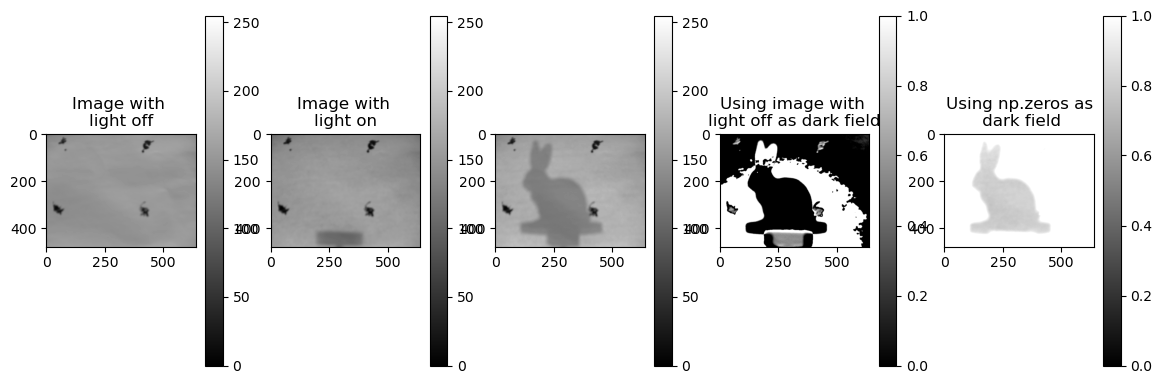

In [8]:
plt.figure(figsize=(14,10))
plt.subplot(2, 5, 1)
plt.title("Image with \nlight off")
plt.imshow(I_dark, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2, 5, 2)
plt.title("Image with \nlight on")
plt.imshow(I_white, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

if len(I_raw.shape) == 2:

    plt.subplot(2, 5, 3)
    plt.imshow(I_raw, cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.imshow(I_flat1, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    
    plt.subplot(2, 5, 5)
    plt.imshow(I_flat2, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
else:
    plt.subplot(2, 5, 3)
    plt.imshow(I_raw[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.title("Using image with \nlight off as dark field")
    plt.imshow(I_flat1[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(2, 5, 5)
    plt.title("Using np.zeros as\n dark field")
    plt.imshow(I_flat2[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()


In [9]:
I_flat = I_flat2

In [10]:
if not os.path.exists(data_path + "/flat_images"):
    os.mkdir(data_path + "/flat_images")

for i, img in enumerate(I_flat):
    imwrite(data_path + "/flat_images/projection_" + str(i).zfill(4) + ".tif", img)

In [11]:
#sod = 43
#sod =47
#sod = 48
#sdd = 61
#for rabbit
#sod=41
#sdd=51
sod=104
sdd=130
#sod = 25
#sdd=61

In [12]:
Ti90Al10 = 5.68
x_src = 0
y_src = 0
z_src = sod

x_det = 0
y_det = 0
z_det = -(sdd - sod)

x_obj1 = 5
y_obj1 = 0
z_obj1 = 0

x_obj2 = 5
y_obj2 = 0
z_obj2 = 0

alpha_x = 0 
alpha_y = 0
alpha_z = 0

x_rot = 0
y_rot = 0
z_rot = 0

x_default = [
    x_src,
    y_src,
    z_src,

    x_det,
    y_det,
    z_det,

    x_obj1,
    y_obj1,
    z_obj1,

    alpha_x, 
    alpha_y,
    alpha_z,

    x_obj2,
    y_obj2,
    z_obj2,

#     x_rot,
#     y_rot,
#     z_rot,
]


In [13]:
# Initialise gVXR using our JSON file
json2gvxr.initGVXR(current_folder + "/simulation2.json", "OPENGL", 3, 2)

Create an OpenGL context: 512x512


Wed Nov  8 11:35:07 2023 ---- Create window (ID: -1)
Wed Nov  8 11:35:07 2023 ---- Initialise GLFW
Wed Nov  8 11:35:07 2023 ---- Create an OpenGL window with a 3.2 context.
Wed Nov  8 11:35:07 2023 ---- Make the window's context current
Wed Nov  8 11:35:07 2023 ---- Initialise GLEW
Wed Nov  8 11:35:07 2023 ---- OpenGL vendor: NVIDIA Corporation
Wed Nov  8 11:35:07 2023 ---- OpenGL renderer: NVIDIA GeForce RTX 4060 Ti/PCIe/SSE2
Wed Nov  8 11:35:07 2023 ---- OpenGL version: 3.2.0 NVIDIA 535.104.05
Wed Nov  8 11:35:07 2023 ---- Use OpenGL 4.5.
Wed Nov  8 11:35:07 2023 ---- Initialise the X-ray renderer if needed and if possible


In [14]:
# Load our source properties
json2gvxr.initSourceGeometry()
json2gvxr.initSpectrum(verbose=0)

gvxr.setSourcePosition(x_src, y_src, z_src, "mm")

Set up the beam
	Source position: [0.0, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [15]:
# Load our detector
json2gvxr.initDetector()
    # "NumberOfPixels": [2880, 2880],

gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

if utils.use_padding:
    number_of_pixels = gvxr.getDetectorNumberOfPixels();
    gvxr.setDetectorNumberOfPixels(number_of_pixels[0] + 2 * pad_width, number_of_pixels[1] + 2 * pad_width);

Set up the detector
	Detector position: [0.0, 0.0, 0.0, 'mm']
	Detector up vector: [0, -1, 0]
	Number of pixels: [640, 480]
	Detector number of pixels: [640, 480]


Wed Nov  8 11:35:07 2023 ---- Initialise the renderer


	Pixel spacing: [0.23, 0.23, 'mm']


In [16]:
# Load our samples
json2gvxr.initSamples(verbose=0)

gvxr.setDensity("cuboid", Ti90Al10, "g/cm3")

Wed Nov  8 11:35:07 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/MyProjects/Rabbit.stl	nb_faces:	75710	nb_vertices:	227130	bounding_box (in cm):	(-4.47596e-08, -1.23532e-07, -9.08006e-08)	(2.28946, 2.54, 2.40125)
Wed Nov  8 11:35:07 2023 (WW) PolygonMesh cuboid not found in g_p_polygon_mesh_set.


In [17]:
# ID = "cuboid"
# gvxr.rotateNode(ID, 90, 1.0, 0.0, 0.0)
# gvxr.moveToCentre()
# gvxr. applyCurrentLocalTransformation(ID)

# alpha_x = 0
# alpha_y = 0
# alpha_z = 0

# x_obj = 0
# y_obj = 0
# z_obj = 0

In [18]:
visualise()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

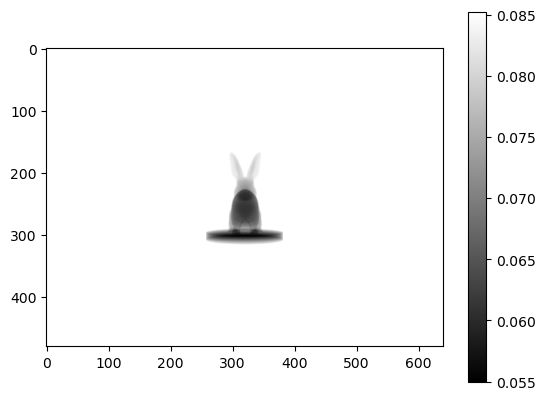

In [19]:
# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(), cmap="gray")
plt.colorbar()
plt.show()

In [22]:
utils.ref_image, utils.selected_angles = getReference(I_flat, angles_in_deg, 1)

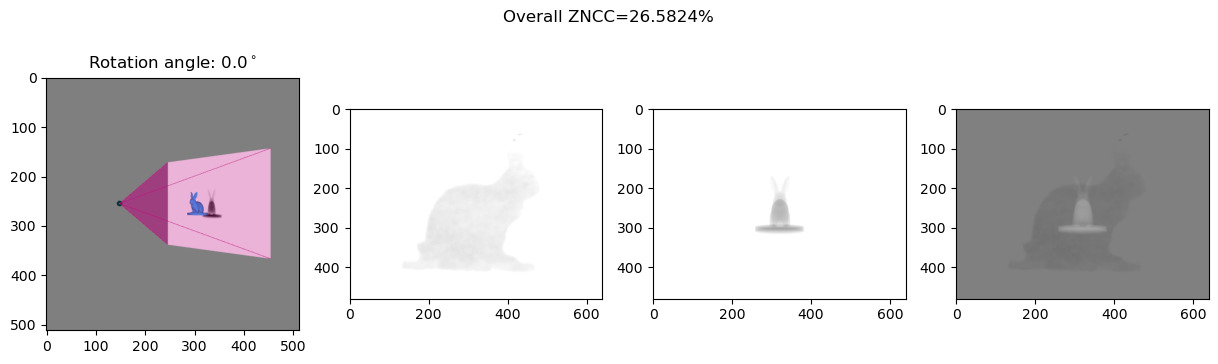

In [23]:
displayResult(x_default)

In [24]:
# opts = cma.CMAOptions()
# opts.set('tolfun', 1e-4);
# opts['tolx'] = 1e-4;
# opts['bounds'] = [np.hstack((12*[-1000], [-180, -180])), np.hstack((12*[1000], [180, 180]))];

# fname = current_folder + "/" + data_path + "/x_best1.dat"
# if not os.path.exists(fname):
    
#     best_fitness = sys.float_info.max
#     fitness_set = []
#     counter = 1
    
#     start_time = time.time();
#     es = cma.CMAEvolutionStrategy(x_default, 0.5, opts);
#     es.optimize(fitnessMAE);
#     elapsed_time = time.time() - start_time

#     x_best1 = es.result.xbest
#     np.savetxt(fname, x_best1)

#     fitness_set = np.array(fitness_set)
#     np.savetxt(current_folder + "/" + data_path + "/fitness_set1.dat", fitness_set)
# else:
#     x_best1 = np.loadtxt(fname)
#     fitness_set = np.loadtxt(fname, current_folder + "/" + data_path + "/fitness_set1.dat")

In [25]:
# plt.plot(fitness_set[:,0], fitness_set[:,1])

In [26]:
# print(x_best1)

In [27]:
# displayResult(x_best1)

In [28]:
# opts = cma.CMAOptions()
# opts.set('tolfun', 1e-3);
# opts['tolx'] = 1e-3;
# opts['bounds'] = [np.hstack((12*[-1250], [-180, -180])), np.hstack((12*[1250], [180, 180]))];

# fname = current_folder + "/" + data_path + "/x_best2.dat"
# if True:
#     # not os.path.exists(fname):

#     best_fitness = sys.float_info.max
#     fitness_set = []
#     counter = 1

#     start_time = time.time();
#     es = cma.CMAEvolutionStrategy(x_best1, 0.25, opts);
#     es.optimize(fitnessMSE);
#     elapsed_time = time.time() - start_time

#     x_best2 = es.result.xbest
#     np.savetxt(fname, x_best2)

#     fitness_set = np.array(fitness_set)
#     np.savetxt(current_folder + "/" + data_path + "/fitness_set2.dat", fitness_set)
# else:
#     x_best2 = np.loadtxt(fname)
#     fitness_set = np.loadtxt(fname, current_folder + "/" + data_path + "/fitness_set2.dat")

In [29]:
# plt.plot(fitness_set[:,0], fitness_set[:,1])

In [30]:
# print(x_best2)

In [31]:
# displayResult(x_best2)

In [32]:
utils.ref_image, utils.selected_angles = getReference(I_flat, angles_in_deg, 2)

In [42]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-4;
opts['bounds'] = [np.hstack((12*[-1000], [-180, -180])), np.hstack((12*[1000], [180, 180]))];

fname = current_folder + "/" + data_path + "/x_best3.dat"
if True:
# if not os.path.exists(fname):

    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1

    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_default, 0.5, opts);
    es.optimize(fitnessMSE);
    elapsed_time = time.time() - start_time

    x_best3 = es.result.xbest
    np.savetxt(fname, x_best3)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savetxt(current_folder + "/" + data_path + "/fitness_set3.dat", utils.fitness_set)
else:
    x_best3 = np.loadtxt(fname)
    utils.fitness_set = np.loadtxt(fname, current_folder + "/" + data_path + "/fitness_set3.dat")

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=515875, Wed Nov  8 11:39:27 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 3.614726942032576e-03 1.0e+00 4.90e-01  5e-01  5e-01 0:00.6
    2     24 3.598895156756043e-03 1.2e+00 4.94e-01  5e-01  5e-01 0:01.1
    3     36 3.590283449739218e-03 1.2e+00 5.06e-01  5e-01  5e-01 0:01.6
   10    120 3.219593549147248e-03 1.4e+00 1.31e+00  1e+00  1e+00 0:05.1
   19    228 2.789943711832166e-03 1.6e+00 4.47e+00  4e+00  5e+00 0:09.4
   30    360 2.478030975908041e-03 2.0e+00 4.98e+00  4e+00  6e+00 0:14.5
   43    516 2.059567021206021e-03 2.8e+00 3.53e+00  3e+00  4e+00 0:20.8
   58    696 1.572456094436347e-03 3.6e+00 2.40e+00  2e+00  3e+00 0:27.9
   75    900 1.428081071935594e-03 4.6e+00 1.52e+00  1e+00  2e+00 0:36.3
   93   1116 1.336848130449653e-03 8.3e+00 1.48e+00  1e+00  2e+00 0:45.3
  100   1200 1.259261043742299e-03 9.7e+00 1.66e+00  1e+00  2e+00 0:48.9
  123   1476 1.087703974917531e-0

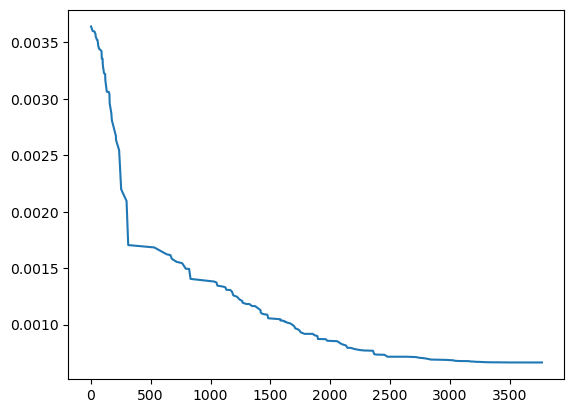

In [43]:
plt.plot(utils.fitness_set[:,0], utils.fitness_set[:,1])

In [44]:
print(x_best3)

[ 38.66082857 -15.77027285  70.45967765 -72.48970155  47.84717259
 -85.35398601  11.15762808  -5.17470658   3.59429013  22.43928656
 -17.53049264 -19.27615702   3.60208354 -14.38239333 -18.8007285 ]


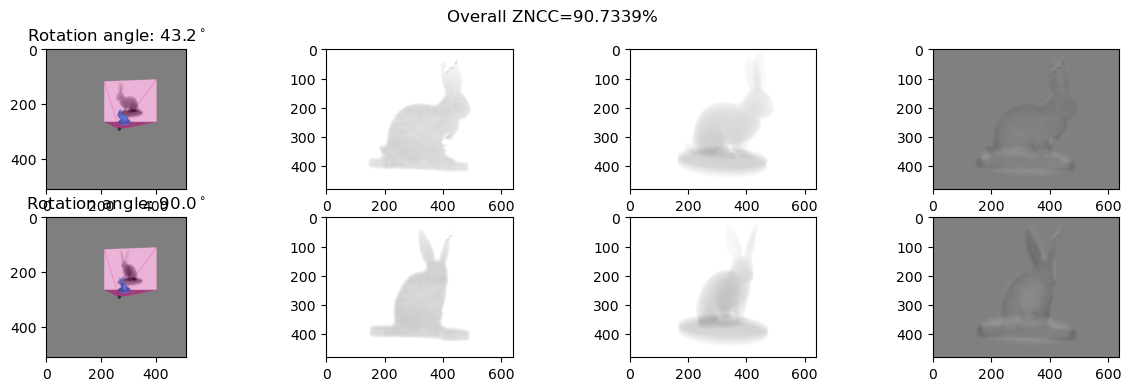

In [48]:
displayResult(x_best3)

In [49]:
# ref_image, selected_angles = getReference(I_flat, angles_in_deg, len(angles_in_deg))
utils.ref_image, utils.selected_angles = getReference(I_flat, angles_in_deg, 7)

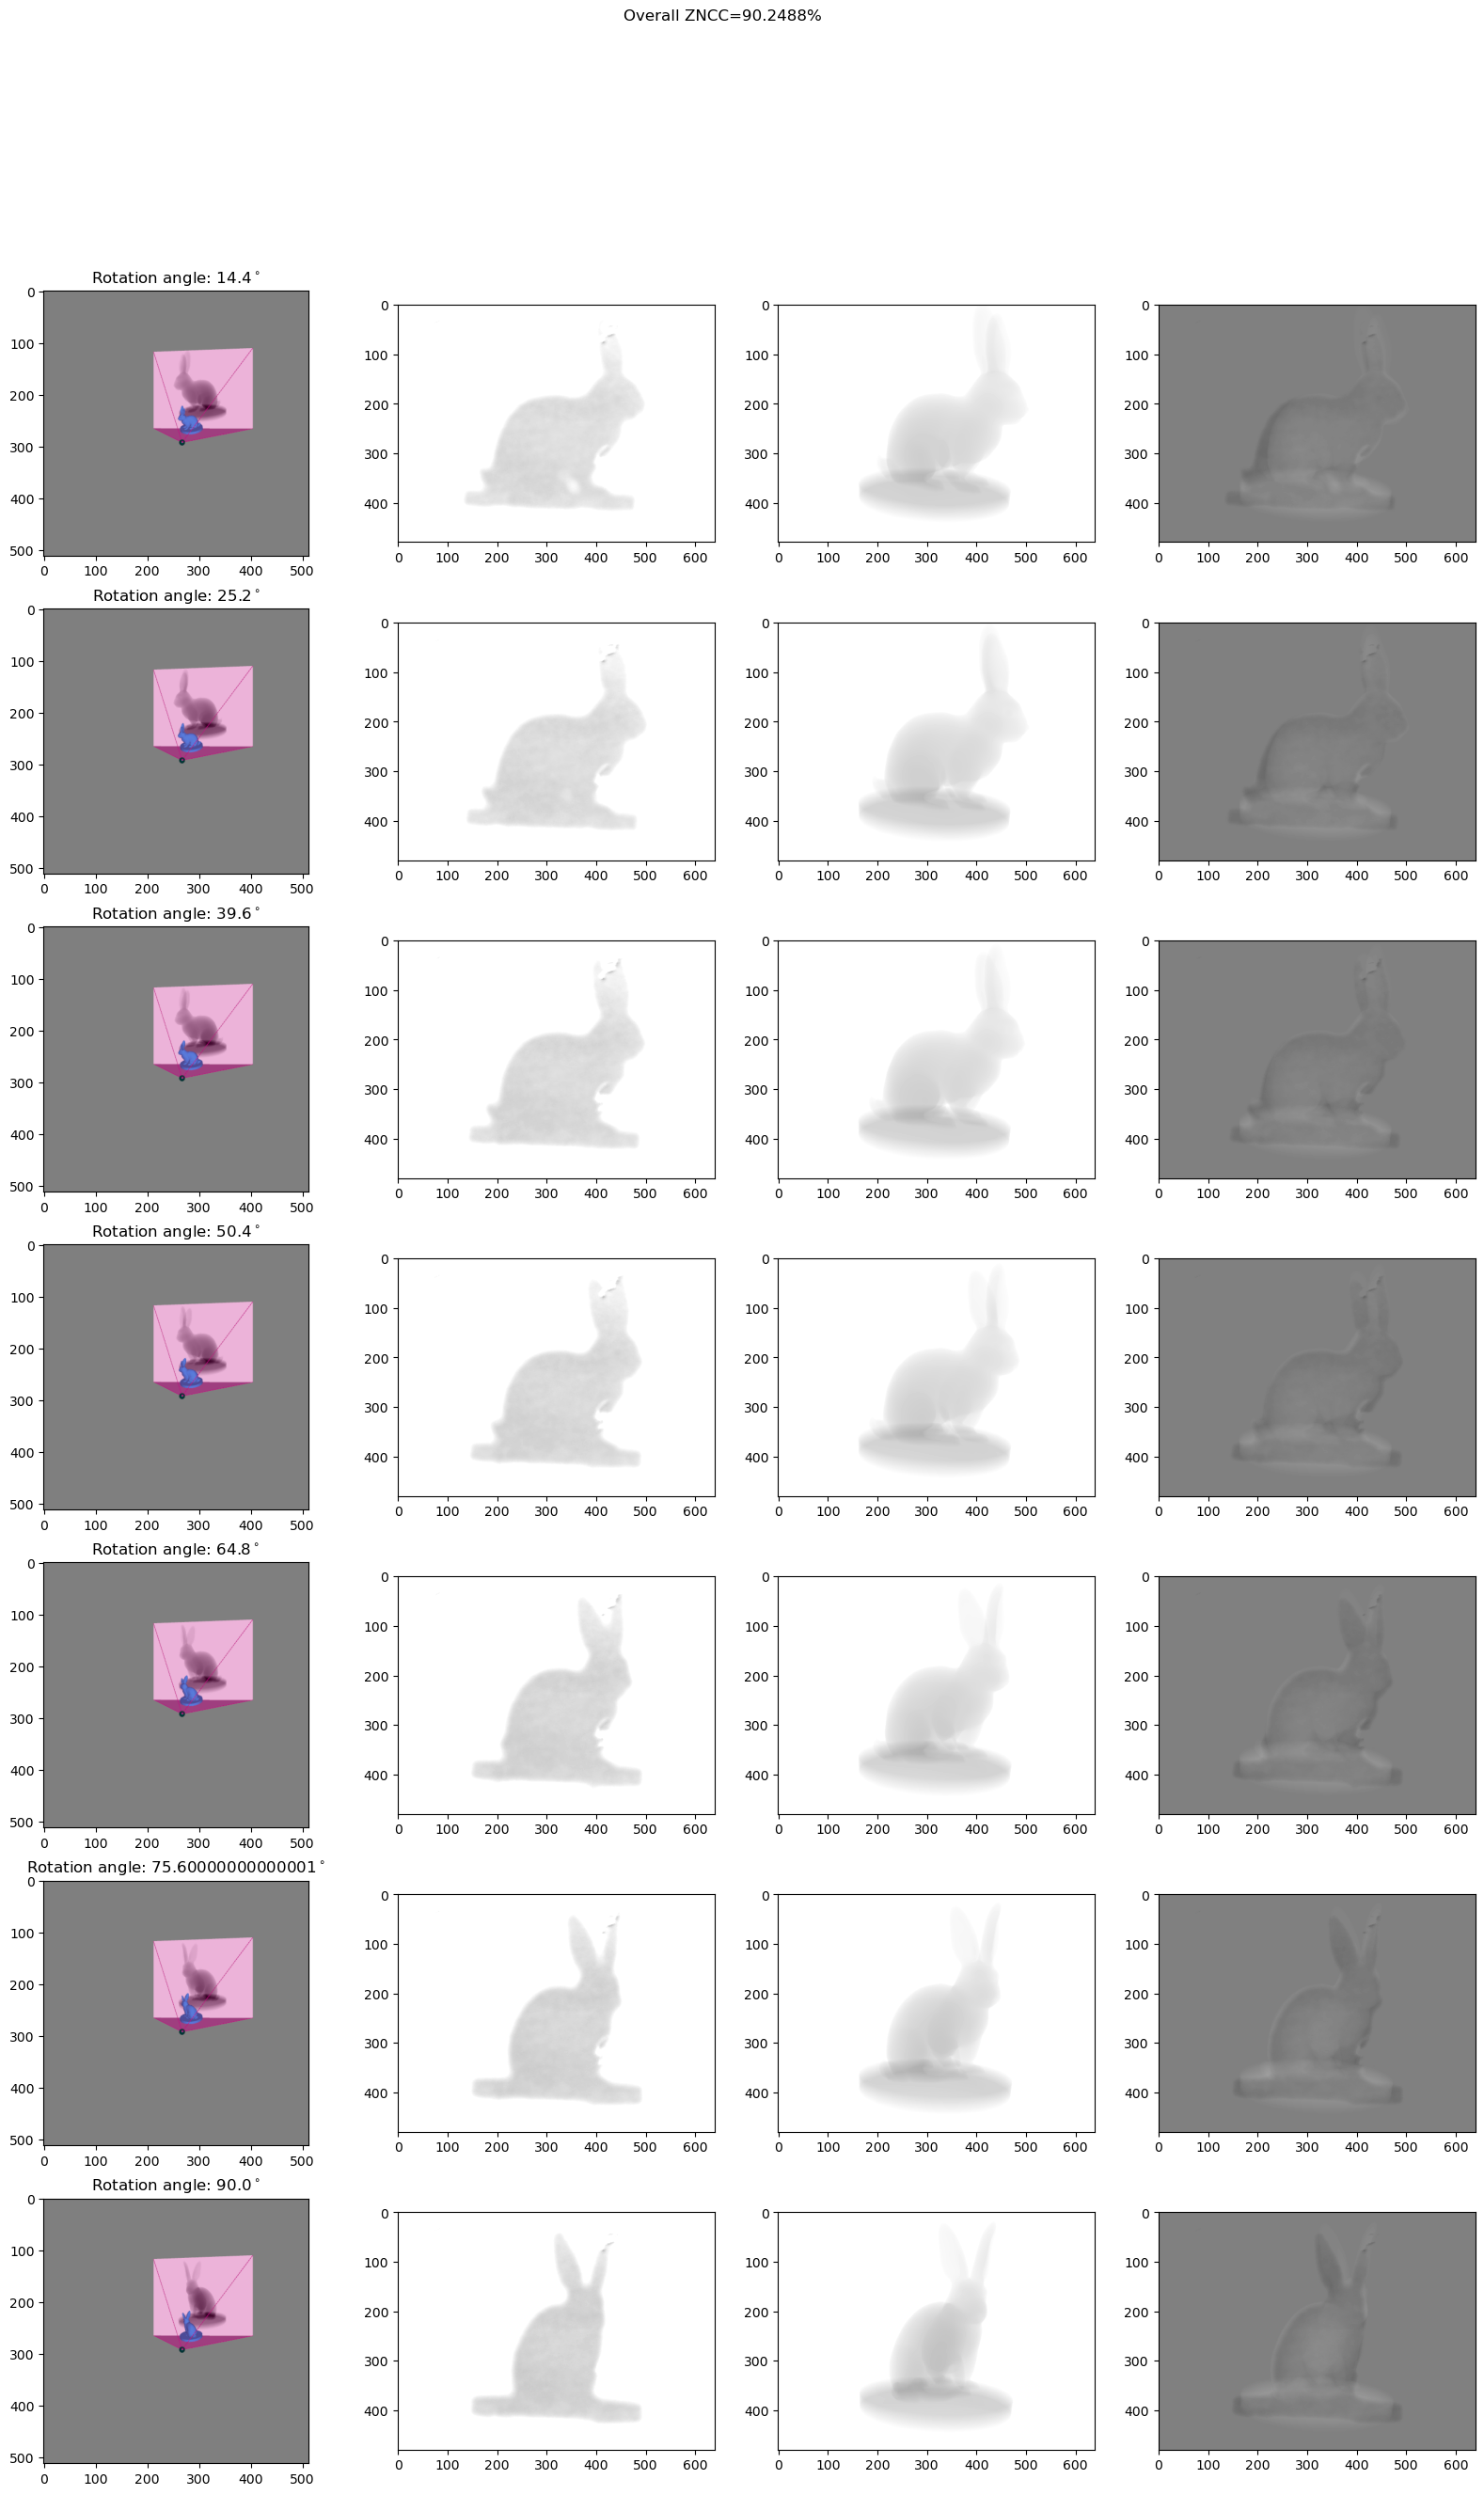

In [50]:
displayResult(x_best3, figsize=(20,30))

In [53]:
def getCentreOfRotationPosition(x):
    return [x[6], x[7], x[8]]
    
def printX(x):

    # Move source, det, object using x
    x_src = x[0]
    y_src = x[1]
    z_src = x[2]
    
    x_det = x[3]
    y_det = x[4]
    z_det = x[5]

    x_obj1 = x[6]
    y_obj1 = x[7]
    z_obj1 = x[8]

    # alpha_x = x[9]
    # alpha_y = x[10]
    # alpha_z = x[11]

    x_obj2 = x[12]
    y_obj2 = x[13]
    z_obj2 = x[14]

        
        
    # #     gvxr.translateNode("root", x_rot_axis_pos, y_rot_axis_pos, z_rot_axis_pos, "mm")
    
        
    #     gvxr.rotateNode("root", rot_angle, up_vector[0], up_vector[1], up_vector[2])
        
    #     gvxr.translateNode("root", x_obj1, y_obj1, z_obj1, "mm")

    #     gvxr.rotateNode("root", alpha_x, 1, 0, 0)
    #     gvxr.rotateNode("root", alpha_y, 0, 1, 0)
    #     gvxr.rotateNode("root", alpha_z, 0, 0, 1)
        
    #     gvxr.translateNode("root", -x_obj2, -y_obj2, -z_obj2, "mm")
        
    #     test_image.append(gvxr.computeXRayImage())
    
    #     if take_screenshot:

    #         gvxr.displayScene()        
    #         screenshot.append(gvxr.takeScreenshot())
        
    #     gvxr.setLocalTransformationMatrix("root", backup)

        
        
        
    print("Source position:", x_src, y_src, z_src, "mm")
    print("Detector position:", x_det, y_det, z_det, "mm")
    print("Source-Detector Distance (SDD):", math.sqrt(math.pow(x_src - x_det, 2) + math.pow(y_src - y_det, 2) + math.pow(z_src - z_det, 2)), "mm")
    print("Object position:", x_obj2, y_obj2, z_obj2, "mm")
    print("Centre of rotation position:", getCentreOfRotationPosition(x), "mm")
    
printX(x_best3)

Source position: 38.660828570672656 -15.77027284732864 70.45967764864011 mm
Detector position: -72.48970155077231 47.84717258901211 -85.35398600588037 mm
Source-Detector Distance (SDD): 201.69163961743203 mm
Object position: 3.602083536462951 -14.382393327441992 -18.80072849637618 mm
Centre of rotation position: [11.15762808263849, -5.1747065762733735, 3.5942901253597306] mm


In [55]:



def saveJSON(fname, image_path):
    dictionary = {}

    dictionary["WindowSize"] = [800, 450]
    dictionary["Detector"] = {}
    dictionary["Detector"]["Position"] = [
        gvxr.getDetectorPosition("cm")[0] / gvxr.getUnitOfLength("cm"),
        gvxr.getDetectorPosition("cm")[1] / gvxr.getUnitOfLength("cm"),
        gvxr.getDetectorPosition("cm")[2] / gvxr.getUnitOfLength("cm"),
        "cm"]
    dictionary["Detector"]["UpVector"] = gvxr.getDetectorUpVector(),
    dictionary["Detector"]["NumberOfPixels"] = gvxr.getDetectorNumberOfPixels()
    dictionary["Detector"]["Size"] = [
        gvxr.getDetectorSize("cm")[0] / gvxr.getUnitOfLength("cm"),
        gvxr.getDetectorSize("cm")[1] / gvxr.getUnitOfLength("cm"),
        "cm"]

    dictionary["Source"] = {}
    dictionary["Source"]["Position"] = [
        gvxr.getSourcePosition("cm")[0] / gvxr.getUnitOfLength("cm"),
        gvxr.getSourcePosition("cm")[1] / gvxr.getUnitOfLength("cm"),
        gvxr.getSourcePosition("cm")[2] / gvxr.getUnitOfLength("cm"),
        "cm"]
    dictionary["Source"]["Shape"] = "PointSource"
    dictionary["Source"]["Beam"] = []
    
    for energy, count in zip(gvxr.getEnergyBins("keV"), gvxr.getPhotonCountEnergyBins()):
        dictionary["Source"]["Beam"].append({})
        dictionary["Source"]["Beam"][-1]["Energy"] = energy
        dictionary["Source"]["Beam"][-1]["Unit"] = "keV"
        dictionary["Source"]["Beam"][-1]["PhotonCount"] = count

    dictionary["Samples"] = json2gvxr.params["Samples"]

    dictionary["Scan"] = {}
    dictionary["Scan"]["CenterOfRotation"] = [0, 0, 0]
    dictionary["Scan"]["FinalAngle"] = 360
    dictionary["Scan"]["IncludeFinalAngle"] = True
    dictionary["Scan"]["NumberOfProjections"] = 600
    dictionary["Scan"]["OutFolder"] = image_path


    
    # Convert and write JSON object to file
    with open(fname, "w") as outfile: 
        json.dump(dictionary, outfile)

saveJSON(current_folder + "/" + data_path + "/visible_light.json", data_path + "/flat_images/")
saveJSON(current_folder + "/" + data_path + "/simulation.json", data_path + "/simulation/")
# for i, img in enumerate(I_flat):
#     imwrite(data_path + "/flat_images/projection_" + str(i).zfill(4) + ".tif", img)